### Fetch our dataset from the correspSearch API

In [99]:
import requests
import xml.etree.ElementTree as ET

In [142]:
# call correspSearch API and write response into a new xml file in the specified directory

response = requests.get("https://correspSearch.net/api/v2.0/tei-xml.xql?p=http://sws.geonames.org/2778067&d=1880-01-01-1890-12-31")

with open("./xml/cs-fetch.xml", "w") as f:
    f.write(response.text)

### Preliminary setup

In [146]:
# get the root element of our input data
tree = ET.parse("./xml/cs-fetch.xml")
root = tree.getroot()

# define all namespaces used within the input file
ns = {'xml': 'http://www.w3.org/1999/xhtml', 'tei': 'http://www.tei-c.org/ns/1.0'}

# find all correspDescs so that we can fetch the information from each individual letter
all_correspdesc = root.findall(".//tei:correspDesc", ns)

# define our lists
nodes = []
edges = []

### Compile our nodes and edges lists


desired output is:
- a list of all nodes in the network (all unique senders and recipients of letters). Each item should have the following format: [(person-id, {"name": "name-string"}), ...]
- a list of all the edges in the format [('sender','recipient'), ...]. 

Using this data we can create a directed and weighted network in the next steps.

In [147]:
# collect all unique <persNames> in <correspAction type="sent"> and write them into the nodes list

import random

def random_id_generator():
    number = random.randint(0, 999999)
    return f"pers_{number:06d}"


# Dictionary to store sender_id as key and sender_name as value (first occurrence only)
unique_correspondants= {}

for correspdesc in all_correspdesc:
    sender_pers_names = correspdesc.findall("./tei:correspAction[@type='sent']/tei:persName", ns)
    recipients_pers_names = correspdesc.findall("./tei:correspAction[@type='received']/tei:persName", ns)

    senders = []
    receivers = []

    for sender in sender_pers_names:
        
        if sender.get("ref") is not None:
            sender_id = sender.get("ref")
        else:
            sender_id = random_id_generator()
        sender_name = sender.text
        senders.append(sender_id)
# Store only the first occurrence of each sender_id
        if sender_id and sender_id not in unique_correspondants:
            unique_correspondants[sender_id] = {"name":sender_name}

    for receiver in recipients_pers_names:
        if receiver.get("ref") is not None:
            receiver_id = receiver.get("ref")
        else:
            receiver_id = random_id_generator()
        receiver_name = receiver.text
        receivers.append(receiver_id)
# Store only the first occurrence of each sender_id
        if receiver_id and receiver_id not in unique_correspondants:
            unique_correspondants[receiver_id] = {"name":receiver_name}

    interum_edges=[(s, r) for s in senders for r in receivers]
    edges = edges + interum_edges

    
print(edges)

for item in unique_correspondants:
    nodes.append([item, unique_correspondants[item]])

        

[('http://d-nb.info/gnd/1029625700', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1029625700', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1029625700', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1029625700', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1028970102', 'http://d-nb.info/gnd/119034557'), ('pers_497006', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1019541296', 'http://d-nb.info/gnd/119034557'), ('pers_281034', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1013263049', 'http://d-nb.info/gnd/119034557'), ('http://d-nb.info/gnd/1013263049', 'http://d-nb.info/gnd/119034557')]


## Drawing the network

In this step we will use the python package [NetworkX](https://networkx.org/documentation/stable/index.html) to draw our networks.

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

nodes:7
edges:6


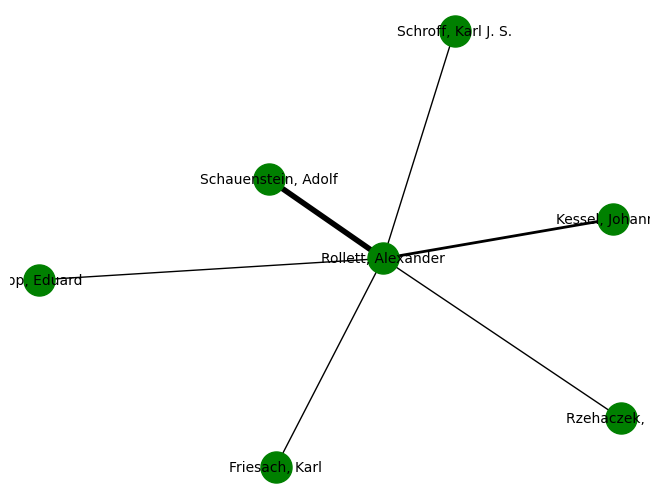

In [149]:

# count repeated edges and same as a dictionary: {("a", "b"): 1, ("a", "c"), etc.}
edge_counts = Counter(edges)  

# convert edges to weighted edges
weighted_edges = [(u, v, {'weight': w}) for (u, v), w in edge_counts.items()]

# create the network
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(weighted_edges)


# some tests to see how many nodes and edges are found in the network
print(f"nodes:{G.number_of_nodes()}")
print(f"edges:{G.number_of_edges()}")


# create label mapping: person-id → name
labels = {node[0]: node[1]["name"] for node in G.nodes(data=True)}
# add weights
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]


# Draw network
nx.draw(
    G,
    pos=nx.spring_layout(G),
    labels=labels,  # use names as labels
    with_labels=True,
    width=edge_weights, 
    node_color="green",
    node_size=500,
    font_size=10,
    font_color='black'
)
plt.show()